In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LassoCV
from collections import Counter
import warnings
import logging

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [5]:
# Suppress all warnings
warnings.filterwarnings("ignore")
# Disable LightGBM info messages
logging.getLogger('lightgbm').setLevel(logging.ERROR)


# **Collection of initial data**

In [6]:
# File path
file_path = "/kaggle/input/dapprojekt24-1/"

# Load training and test datasets
df_train = pd.read_csv(f"{file_path}train.csv")
df_test = pd.read_csv(f"{file_path}test.csv")

# **Data description and data research**

In [7]:
# Display the first 5 rows of the training dataset
df_train.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id
0,2010-01-04,MMM,53.295380,83.019997,83.449997,82.669998,83.089996,3043700.0,0,0
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0,0,1
2,2010-01-06,MMM,53.712681,83.669998,84.599998,83.510002,83.879997,5268500.0,0,2
3,2010-01-07,MMM,53.751179,83.730003,83.760002,82.120003,83.320000,4470100.0,0,3
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0,0,4


In [8]:
# Data types of each column in the dataframe
column_types = df_train.dtypes

print("Data types of each column:")
print(column_types)

Data types of each column:
Date          object
Symbol        object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume       float64
Target         int64
Id             int64
dtype: object


Initially, the data type of the '*Date*' column is identified as 'object'. To work with dates more effectively, we need to convert the 'Date' column from the 'object' data type to the 'date' data type.

In [9]:
# Number of samples (rows)
num_samples = len(df_train)

# Number of features (columns)
num_features = df_train.shape[1]

# Number of unique stocks
num_unique_stocks = df_train['Symbol'].nunique()

# Print the results
print("Number of samples/rows:", num_samples)
print("Number of features/columns:", num_features)
print("Number of unique stocks:", num_unique_stocks)

Number of samples/rows: 501400
Number of features/columns: 10
Number of unique stocks: 200


In [10]:
# Check for missing values in the dataset
missing_values = df_train.isna().sum()

# Print the columns with missing values (if any) and the corresponding counts
if missing_values.sum() == 0:
    print("There are no missing values in the dataset.")
else:
    print("Missing values in the dataset:")
    print(missing_values)

Missing values in the dataset:
Date             0
Symbol           0
Adj Close    27229
Close        27229
High         27229
Low          27229
Open         27229
Volume       27245
Target           0
Id               0
dtype: int64


In [11]:
# Find rows with missing values
rows_with_missing_values = df_train[df_train.isna().any(axis=1)]

# Extract dates for rows with missing values
missing_dates = rows_with_missing_values['Date']

# Print the dates for rows with missing values
print("Dates with missing records:")
print(missing_dates)

Dates with missing records:
500       2011-12-27
501       2011-12-28
502       2011-12-29
503       2011-12-30
504       2012-01-03
             ...    
499663    2013-01-25
499664    2013-01-28
499665    2013-01-29
499666    2013-01-30
499667    2013-01-31
Name: Date, Length: 27245, dtype: object


I wouldn't consider these as missing values because recording for each stock in this dataset begins from the date 04/01/2010 and extends until 31/12/2019.

However, for some stocks, missing these records are possibly because they might not have been listed on the exchange on 04/01/2010 but rather later, and thus prices for these stocks are recorded from later dates.

In [12]:
# Check for duplicates 
duplicates = df_train[df_train.duplicated()]

# If there are duplicates, print information about them
if not duplicates.empty:
    print("Duplicates found in the dataset:")
    print(duplicates)
else:
    print("There are no duplicates in the dataset.")

There are no duplicates in the dataset.


# **Data validation**

In [33]:
# Filter rows where 'Low' prices are higher than 'High' prices
incorrect_daily_price_data  = df_train[df_train['Low'] > df_train['High']]

# If there is any impossible data
if not incorrect_daily_price_data.empty:
    print("Impossible) data found in the dataset:")
    print(incorrect_daily_price_data)
else:
    print("There are no impossible data in the dataset.")

Impossible) data found in the dataset:
             Date Symbol  Adj Close      Close       High        Low  \
60596  2011-09-14   BALL  17.094999  17.094999 -51.885000  16.750000   
60597  2011-09-15   BALL  17.115000  17.115000 -51.750000  17.020000   
60598  2011-09-16   BALL  17.155001  17.155001 -51.764997  16.985001   
60599  2011-09-19   BALL  16.855000  16.855000 -50.774998  16.565001   
60600  2011-09-20   BALL  16.754999  16.754999 -51.270000  16.705000   
...           ...    ...        ...        ...        ...        ...   
60701  2012-02-14   BALL  19.934999  19.934999 -59.909998  19.805000   
60702  2012-02-15   BALL  19.865000  19.865000 -60.105000  19.820000   
60703  2012-02-16   BALL  20.160000  20.160000 -60.584999  19.780001   
60704  2012-02-17   BALL  20.055000  20.055000 -60.750000  20.000000   
60705  2012-02-21   BALL  20.120001  20.120001 -60.735003  20.025000   

            Open     Volume  Target     Id  
60596  17.125000  2850400.0       1  60596  
60597 

In [34]:
# Identify and store information about invalid data in specified columns in cols list
cols = ['Adj Close', 'Close', 'High', 'Low', 'Open']

# Storing information about invalid data
invalid_data_info = {}

# Iterate through each column
for column in cols:
    # Find rows where the column value is less than 0 
    invalid_data = df_train.loc[df_train[column] < 0, :]
    # If there is any invalid data
    if not invalid_data.empty:
        invalid_data_info[column] = invalid_data
        
# If there are any invalid data
if invalid_data_info:
    print("Invalid data found in the following columns:")
    for column, data in invalid_data_info.items():
        print(f"Column: {column}, number of invalid rows: {len(data)}")
else:
    print("There are no invalid data in the specified columns.")


Invalid data found in the following columns:
Column: High, number of invalid rows: 110


There are invalid data in the dataset. Specifically, in the 'High' column, there are 110 rows where the data is wrong because it is not possible for a stock's price to go into the negative territory. 

To address this issue, one possible approach is to examine the context of these invalid data points and determine whether they are outliers or errors in data entry.

Also, depending on the nature of the invalid data, interpolation can be utilized to impute invalid values in the 'High' column. This method leverages the assumption that temporally close values are similar, considering the daily fluctuations in stock prices.  

# **Data visualization and statistical information**

In [35]:
# Statistical summary
summary = df_train[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].describe()

print("Statistical Summary:")
print(summary)

Statistical Summary:
           Adj Close          Close           High            Low  \
count  474171.000000  474171.000000  474171.000000  474171.000000   
mean       68.557799      78.063775      78.793316      77.257284   
std       145.555119     146.684837     148.337565     144.898091   
min         0.700000       0.700000     -60.975002       0.650000   
25%        24.205503      30.860001      31.170000      30.530001   
50%        42.509499      51.540001      52.049999      51.009998   
75%        73.034061      84.540001      85.309998      83.720001   
max      3892.889893    3892.889893    3946.500000    3815.500000   

                Open        Volume  
count  474171.000000  4.741550e+05  
mean       78.038791  7.793082e+06  
std       146.575314  3.203411e+07  
min         0.700000  0.000000e+00  
25%        30.840561  9.811000e+05  
50%        51.529999  2.179300e+06  
75%        84.529999  5.196650e+06  
max      3900.000000  1.880998e+09  


We need to consider that the 'High' column currently contains negative values,
which invalidate the statistical information for this column.
Therefore, we will exclude it from the analysis at the moment.

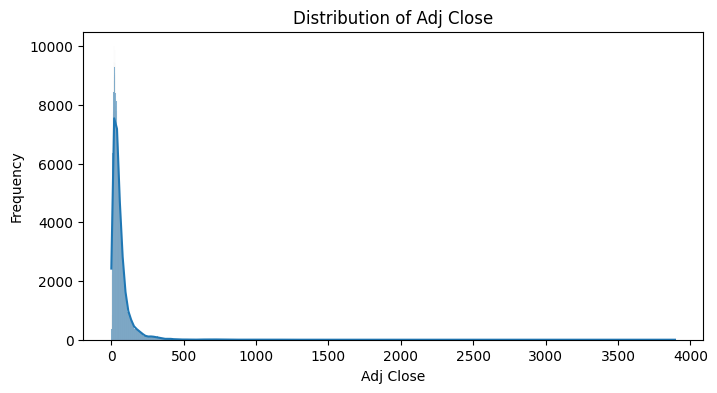

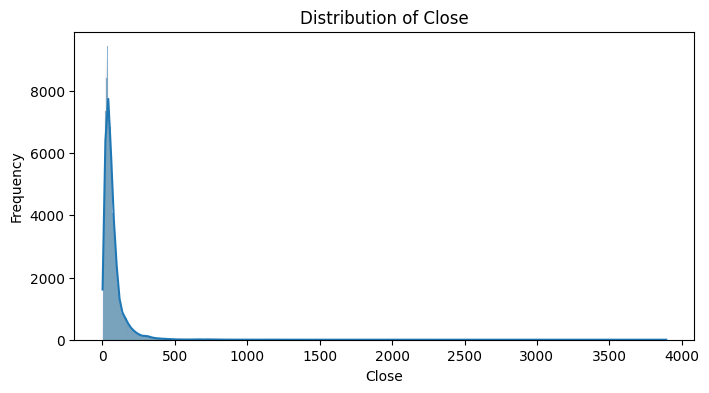

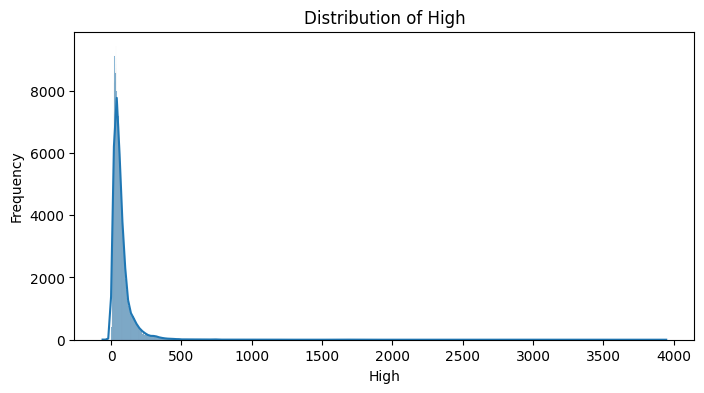

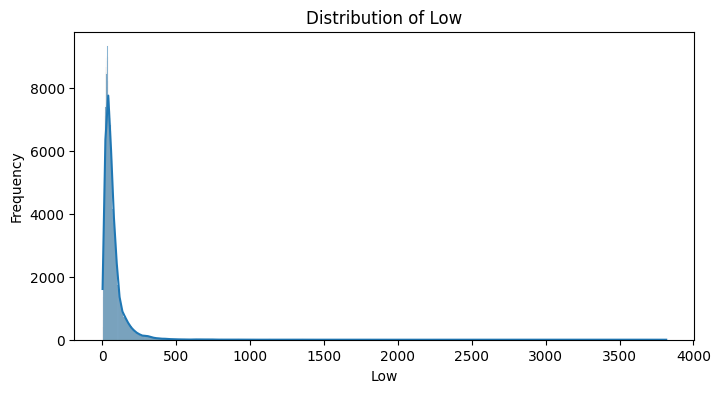

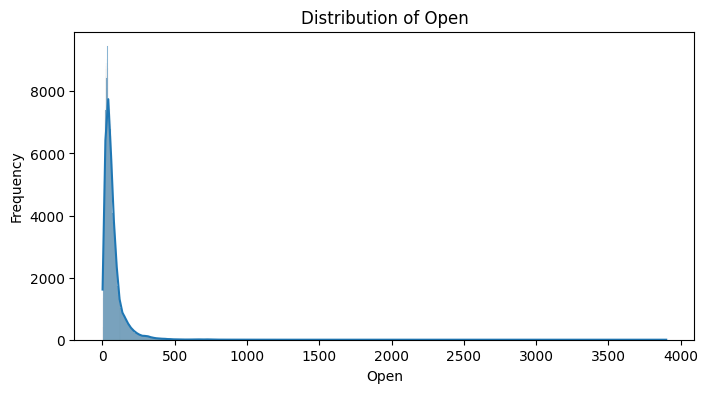

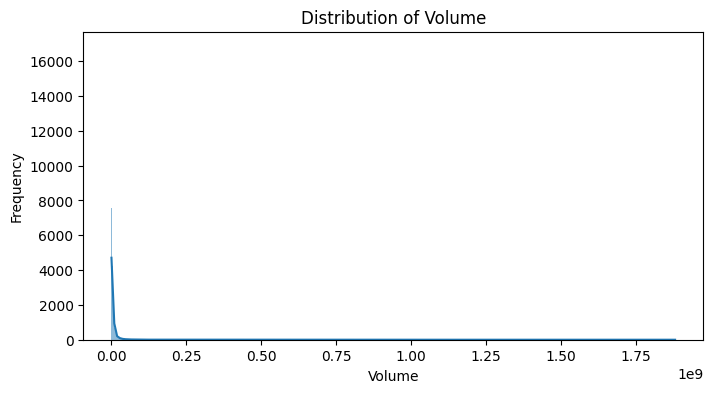

In [36]:
# Histograms for numerical featuress 
numerical_features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_train[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

The histograms display a characteristic long-tail distribution pattern, indicative of a substantial frequency of occurrences at far-reaching values from the central tendency.
Furthermore, within the histogram labeled '*Distribution of High*' there is notable presence of unfeasible negative values, deviating from the expected distribution of non-negative data points.

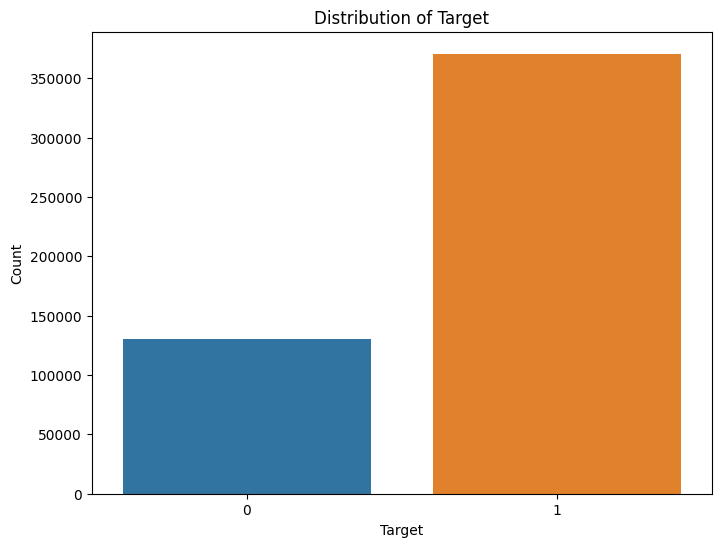

Ratio of 1 against 0 is: 2.835092550099434


In [37]:
# Bar plot for 'Target'
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='Target')
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Calculate the number of occurrences for each class.
count_1 = (df_train['Target'] == 1).sum()
count_0 = (df_train['Target'] == 0).sum()

# Ration
ratio_1_to_0 = count_1 / count_0

print("Ratio of 1 against 0 is:", ratio_1_to_0)

Observing the *target* feature, it is noted that the occurrences where target equals 1, indicating an anticipated increase of at least 2% in the next 2 months, are nearly three times greater than when target equals 0.

In [38]:
def plot_stock_data(stock_data, features, stock_name):
    '''
    Function to create a line plot for a single stock.

    Parameters:
        - stock_data (DataFrame): DataFrame containing stock data, with 'Date' as index.
        - features (list of str): List of features to plot on the y-axis.
        - stock_name (str): Name of the stock.

    Returns:
        - None (displays the plot).
    '''
    # Set figure size
    plt.figure(figsize=(20, 10))
    
    # Plot each feature
    for feature in features:
        plt.plot(stock_data['Date'], stock_data[feature], label=feature)
        
    ax = plt.gca()
    
    # Set x-axis ticks to display every 2 months
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=2))
    

    plt.xticks(rotation=45)
    
    # Add legend
    plt.legend()
    
    # Determine date range considering available data
    min_date = stock_data.loc[stock_data['Open'].notnull(), 'Date'].min()
    max_date = stock_data.loc[stock_data['Open'].notnull(), 'Date'].max()
    
    date_range = f"{min_date} to {max_date}"
      
    # Add title
    plt.title(f"Stock Data for {stock_name} ({date_range})")
    # Show plot
    plt.tight_layout()
    plt.show()

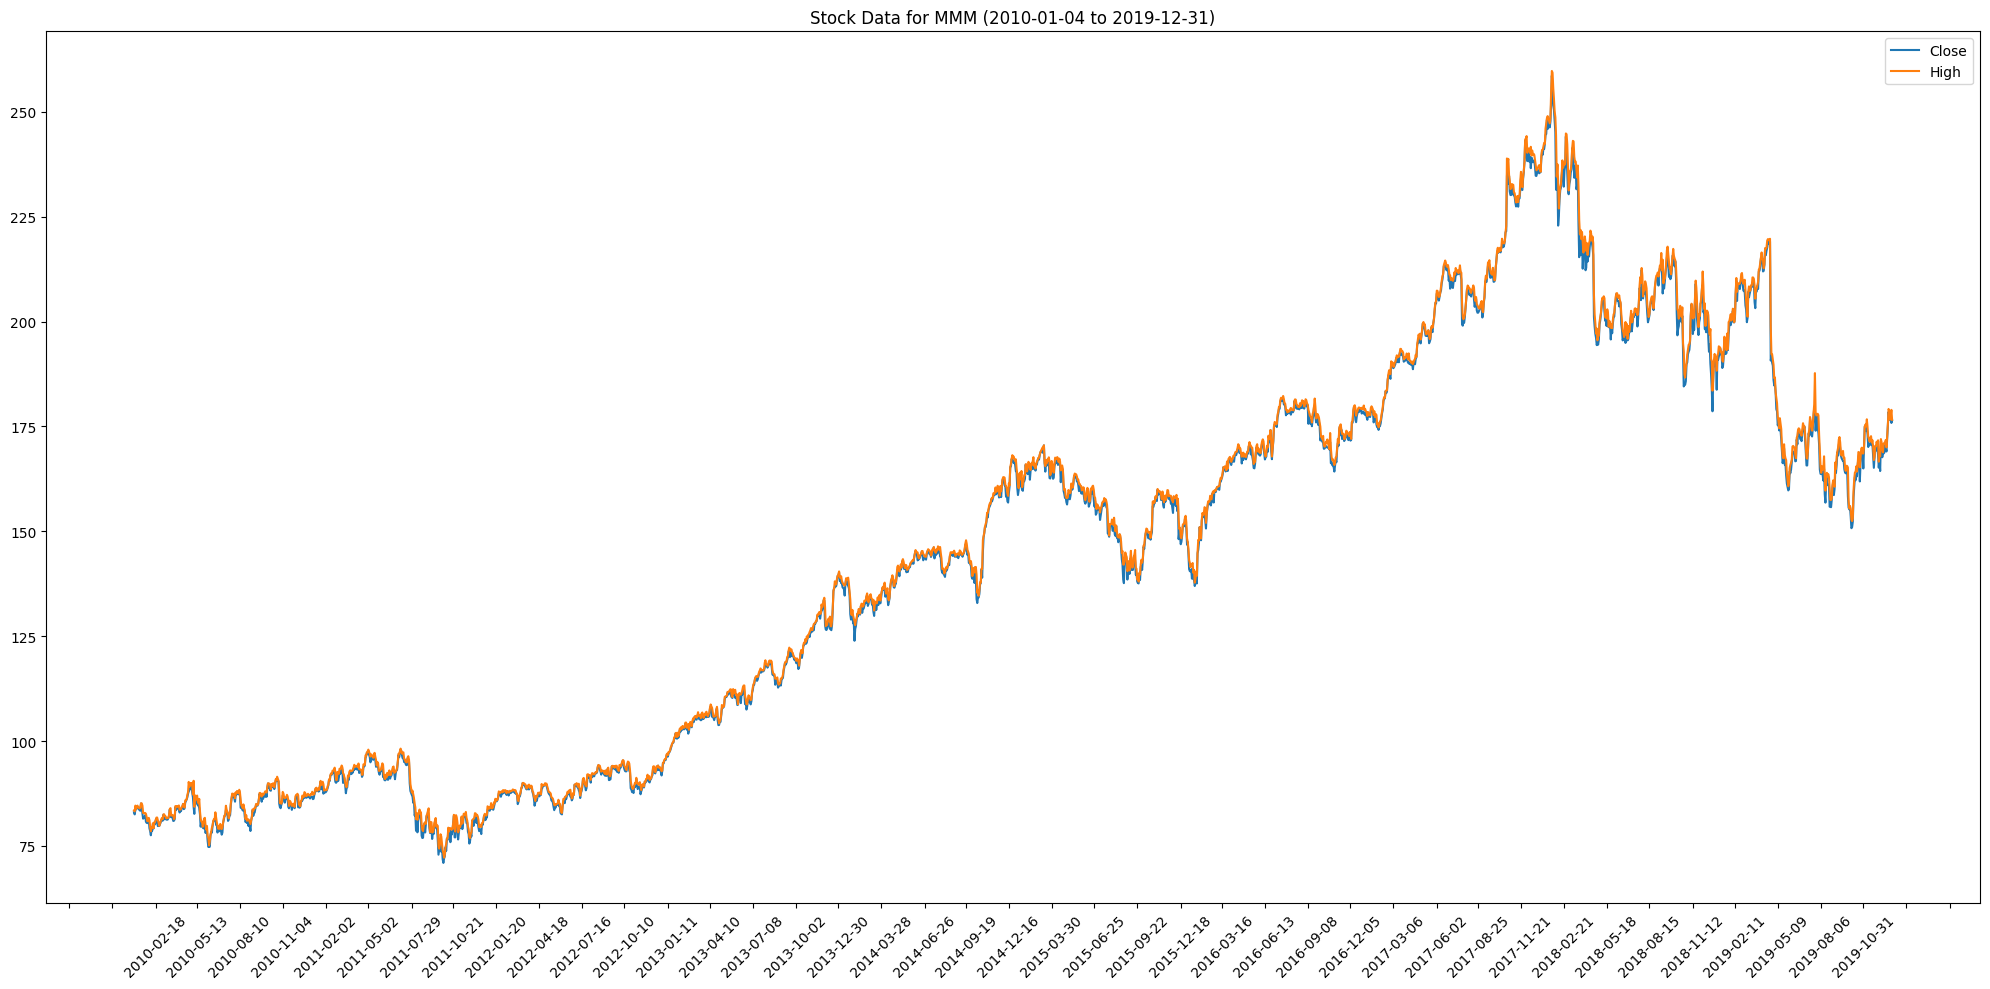

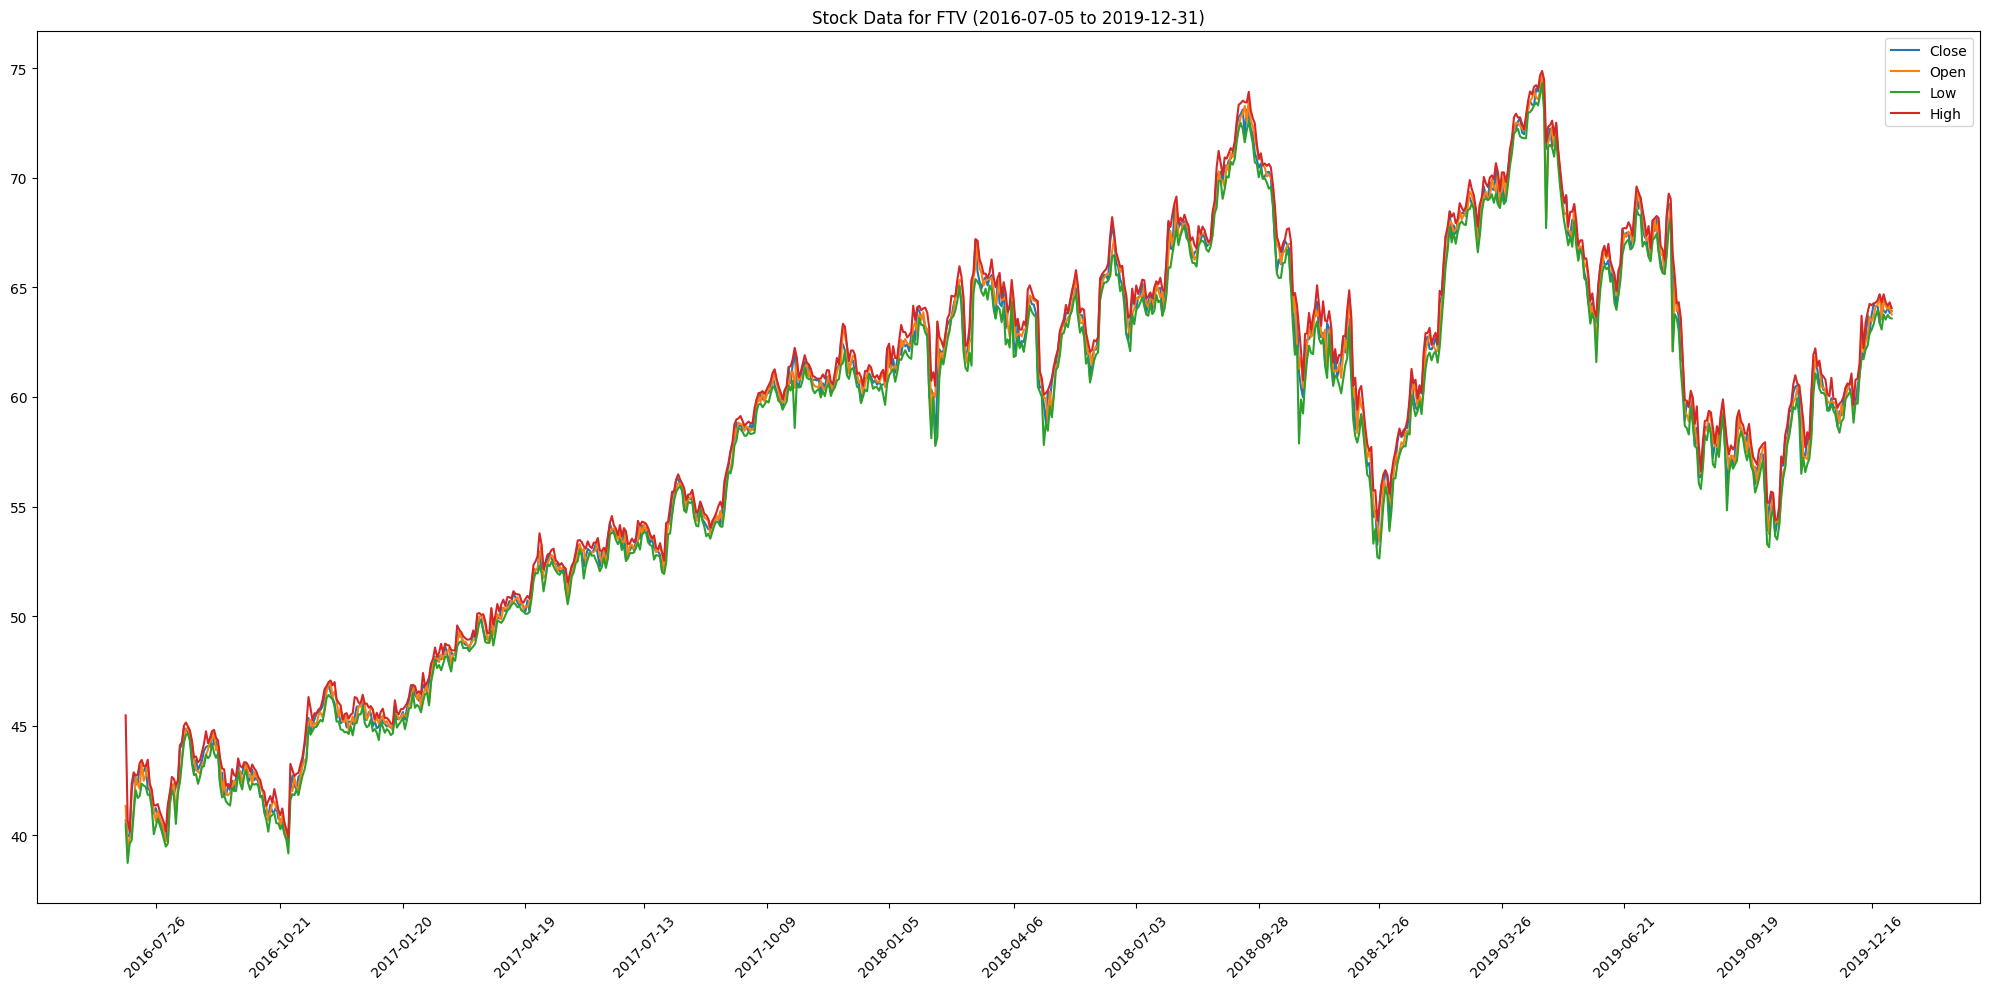

In [39]:
# Example call to plot_stock_data function
stock_names = ['MMM','FTV']
features = [['Close', 'High'],['Close','Open','Low', 'High'] ]

for stock_name,feature in zip(stock_names,features):
    plot_stock_data(stock_data=df_train[df_train['Symbol'] == stock_name], 
                    features=feature, 
                    stock_name=stock_name)

We can notice that we have data for *FTV* shares since 2016-07-05, unlike *MMM* where we have data since 2010-01-04.


We can observe distinct behaviors in the stock prices of '*MMM*' and '*FTV*' on the two graphs. This includes variations in how the stock prices rise and fall, as well as differences in the scale of values. Specifically, '*MMM*' exhibits significantly higher values compared to '*FTV*', indicating that '*MMM*' stock is more valuable than '*FTV*' stock.

In [40]:
def best_stock_to_buy(df_train, target_date):
    # Function for calculating the Sharpe ratio
    def calculate_sharpe_ratio(subset):
        daily_returns = subset['Adj Close'].pct_change().fillna(0)
        avg_daily_return = daily_returns.mean()
        std_dev_daily_return = daily_returns.std()
        risk_free_rate = 0  # Assume the risk-free rate is zero
        sharpe_ratio = (avg_daily_return - risk_free_rate) / std_dev_daily_return
        return sharpe_ratio

    # Function for calculating the Treynor ratio
    def calculate_treynor_ratio(subset):
        daily_returns = subset['Adj Close'].pct_change().fillna(0)
        avg_daily_return = daily_returns.mean()
        beta = 0.9  # Set beta (e.g., as 0.9)
        risk_free_rate = 0  # Assume the risk-free rate is zero
        risk_premium = avg_daily_return - risk_free_rate
        treynor_ratio = risk_premium / beta
        return treynor_ratio

    df_train['Date'] = pd.to_datetime(df_train['Date'])   
    
    # Filtering data for the previous 2 weeks before the target date.
    start_date = pd.to_datetime(target_date) - pd.Timedelta(days=14)
    df_train_filtered = df_train[(df_train['Date'] >= start_date) & (df_train['Date'] < target_date)]

    # Calculating the price change over the past week for each stock
    df_train_filtered['PriceChange'] = df_train_filtered.groupby('Symbol')['Adj Close'].transform(lambda x: x.pct_change())

    best_stocks_pct_change, best_stocks_sharpe, best_stocks_treynor = -1, -1, -1

    # Initializing variables to track the best stocks for each metric
    best_stocks_pct_change = df_train_filtered.groupby('Symbol')['PriceChange'].mean().idxmax()
    best_stocks_sharpe = df_train_filtered.groupby('Symbol').apply(calculate_sharpe_ratio).idxmax()
    best_stocks_treynor = df_train_filtered.groupby('Symbol').apply(calculate_treynor_ratio).idxmax()

    # Creating a list of the best stocks for each metric
    best_stocks = [best_stocks_pct_change, best_stocks_sharpe, best_stocks_treynor]

    # Selecting the stock that most frequently appears as the best
    most_common_stock = Counter(best_stocks).most_common(1)[0][0]

    print(f"Best stock to buy on {target_date}: {most_common_stock}\n")

    # Assuming plot_stock_data is a function that plots stock data
    plot_stock_data(stock_data=df_train[(df_train['Date'] < target_date)][df_train['Symbol'] == most_common_stock], 
                    features=['Open', 'Close'], 
                    stock_name=most_common_stock)


Best stock to buy on 2017-04-15: VRTX



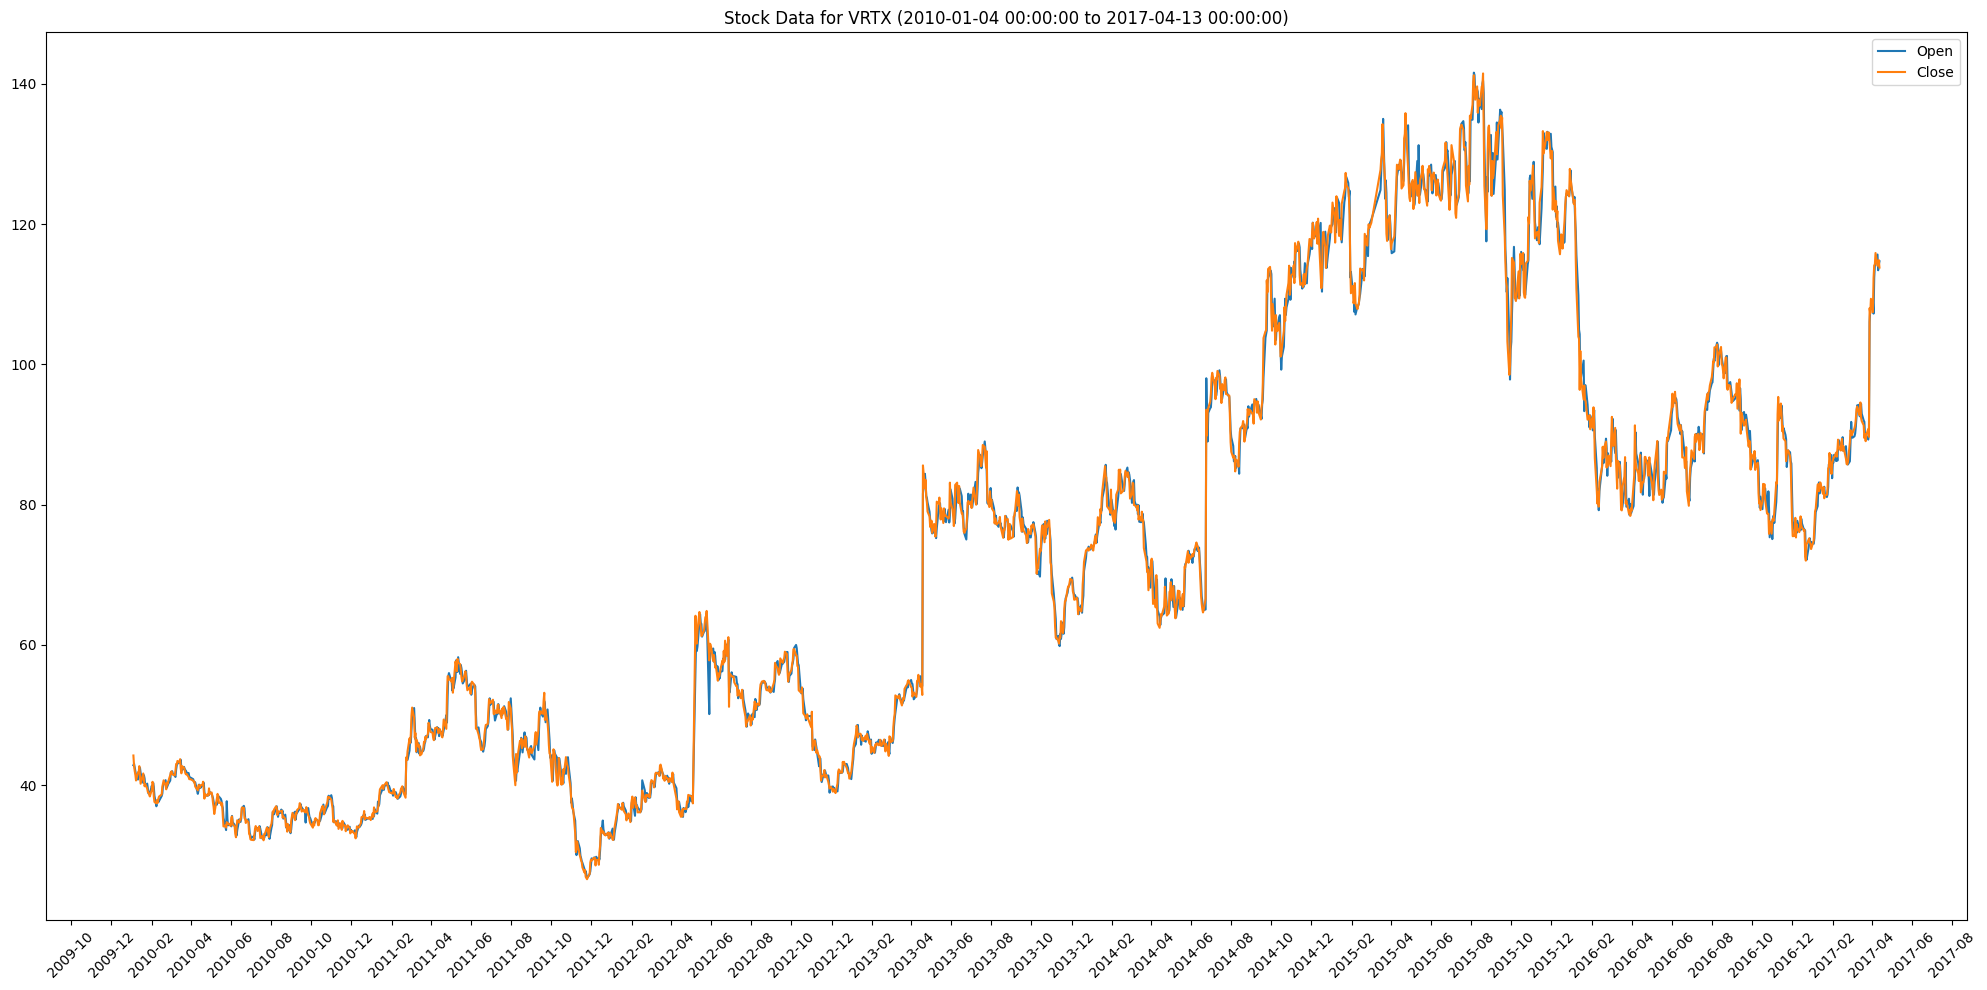

In [41]:
best_stock_to_buy(df_train, '2017-04-15')

Upon analyzing various metrics including percentage change in price over the past two week, Sharpe ratio, and Treynor ratio, we have determined that the stock '*VRTX*' emerges as the optimal choice for investment on April 15, 2017.

Firstly, we utilize the percentage change metric to gauge the short-term performance of each stock. '*VRTX*' exhibits the most substantial price increase over the past week compared to other stocks, suggesting strong momentum leading up to the target date.

Moreover, if we visualize the price trend of '*VRTX*' leading up to April 15, 2017, we observe a steep upward trajectory. This visual representation corroborates our quantitative analysis, suggesting a strong bullish momentum and reinforcing the decision to invest in '*VRTX*'.

# **Building baseline model**

**Displaying the correlation between features**

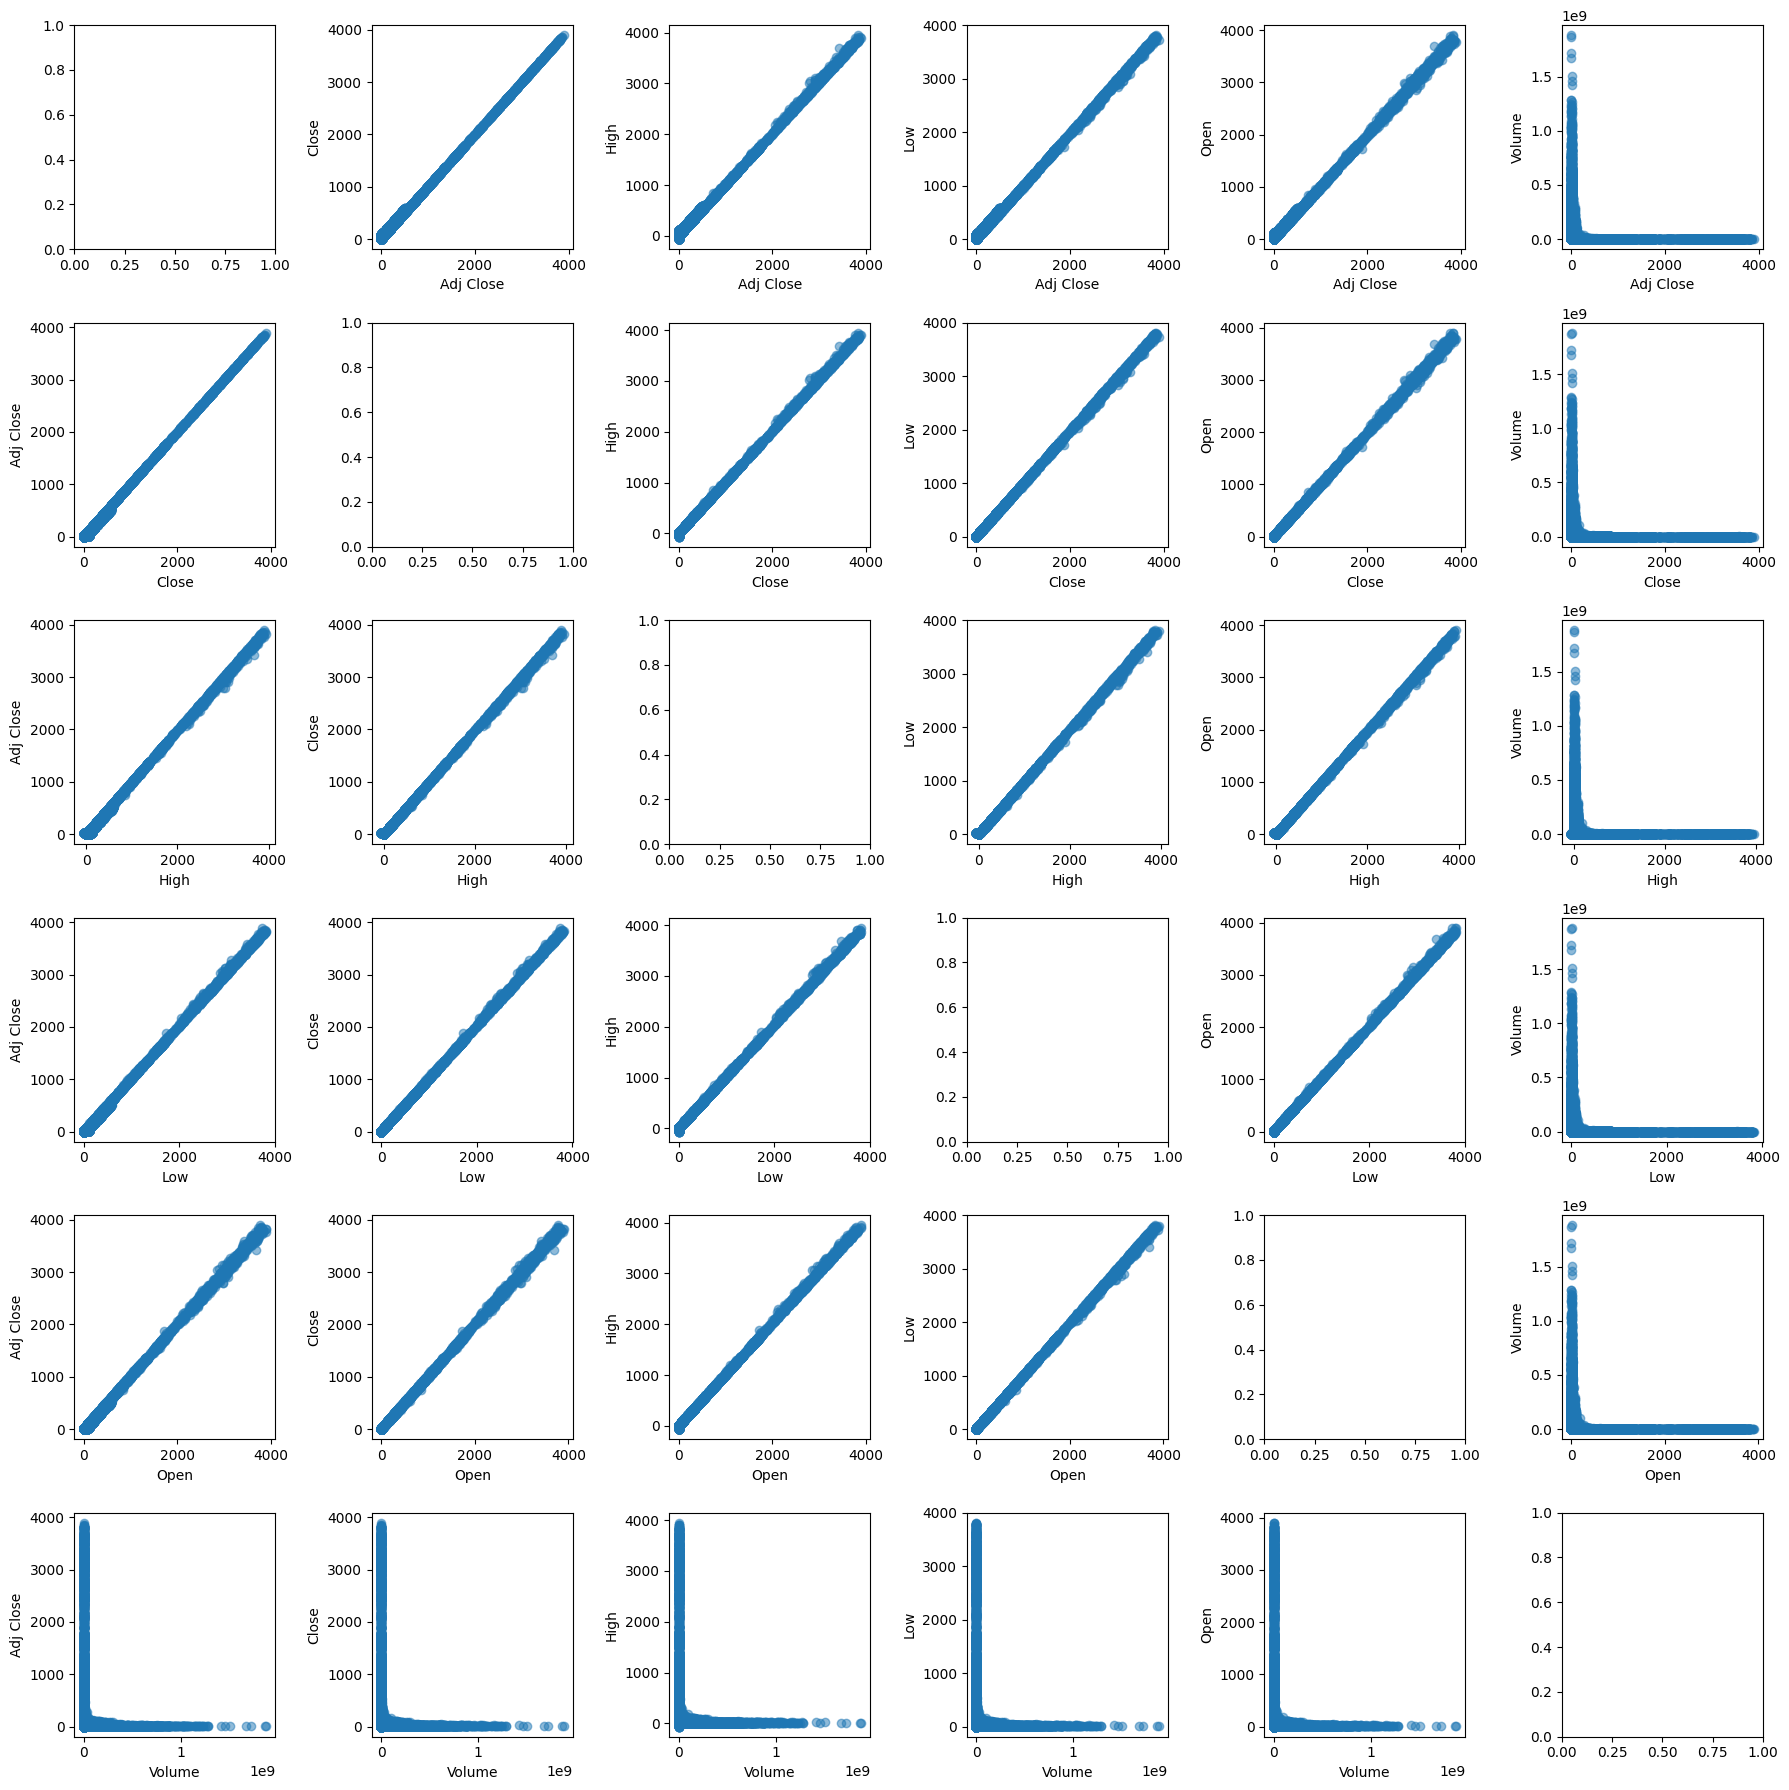

In [42]:
# Selecting features
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 18))

for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        if i != j:
            axes[i, j].scatter(df_train[feature1], df_train[feature2], alpha=0.5)
            axes[i, j].set_xlabel(feature1)
            axes[i, j].set_ylabel(feature2)

plt.tight_layout()
plt.show()

**Creating correlation matrix**

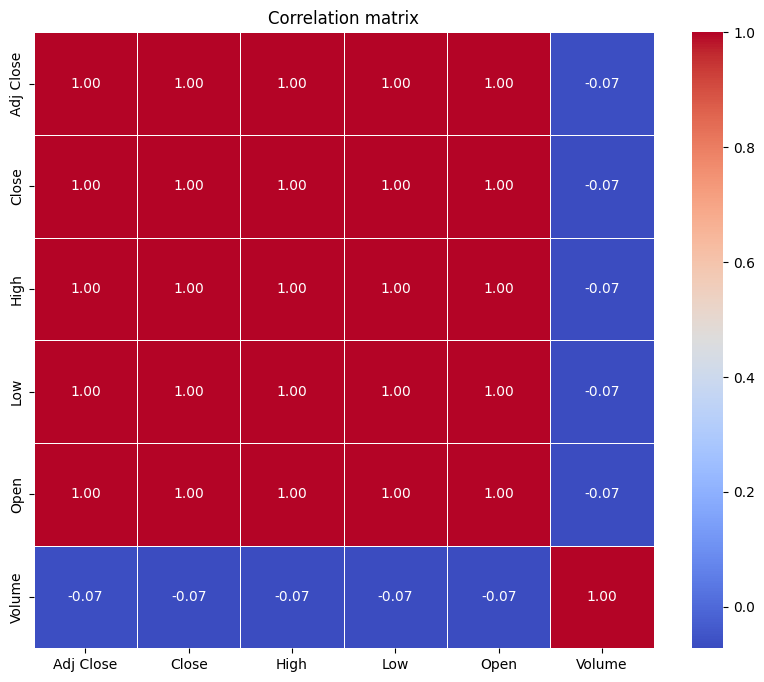

In [43]:
# Selecting features
correlation_matrix = df_train[features].corr()

# Displaying the correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix')
plt.show()

From the visual examination of the scatter plots and the correlation matrix, it is evident that the features '*Adj Close*', '*Close*', '*High*', '*Low*', and '*Open*' exhibit a high degree of linear correlation, as indicated by a correlation coefficient of 1. This implies that these features are perfectly collinear, meaning that one feature can be precisely predicted from a linear combination of the others. Such a scenario poses challenges during model training due to a phenomenon known as multicollinearity.

In [49]:
X = df_train[['Volume']].values
y = df_train['Target'].values

# Initialization models that can handel missing values with default hyperparameters
models = {
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(), 
    'LGBMClassifier': LGBMClassifier(force_col_wise=True), 
    'XGBClassifier': XGBClassifier()
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Define F1 scorer
f1_scorer = make_scorer(f1_score)

# Model evaluation and selection based on the F1 score
scores = {}
for name, model in models.items():
    cv_score = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1)
    scores[name] = np.mean(cv_score), np.std(cv_score)

# Find the best model based on the F1 score
best_model_name = max(scores, key=lambda k: scores[k][0])
print(f"Best model: {best_model_name} with F1-score: {scores[best_model_name][0]:.4f} (+/- {scores[best_model_name][1]:.4f})")

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

Best model: HistGradientBoostingClassifier with F1-score: 0.8779 (+/- 0.0194)



Given the features '*Adj Close*', '*Close*', '*High*', '*Low*', '*Open*', '*Volume*', it is observed that the correlation among '*Adj Close*', '*Close*', '*High*', '*Low*', and '*Open*' is 1. Hence, for model training, only the '*Volume*' feature is utilized, as it is independent of the other features due to their perfect correlation.

Using cross-validation, I have evaluated and selected the best model from a set of models that can handle missing values by default. The selected model is the *HistGradientBoostingClassifier*, which achieved the highest F1-score among the evaluated models.

The HistGradientBoostingClassifier , along with other models like LGBMClassifier and XGBClassifier, inherently handles missing values in the dataset without requiring any additional preprocessing. 

In [45]:
# Training the best model on the entire training set
best_model = HistGradientBoostingClassifier()

best_model.fit(X, y)

# Generating predictions on the test set and saving to a CSV file
X_test = df_test[['Volume']].values
predictions = best_model.predict(X_test)

The selected best model, *LGBMClassifier*, is trained on the entire training dataset. This ensures that the model leverages the full scope of available data to enhance its predictive capabilities.

Following model training, predictions are generated for the test set. Utilizing the same features as the training set, the model predicts the target variable for each data point in the test set. 

In [ ]:
# Save predictions to working directiory - this creates submission file
output = pd.DataFrame({'Id': df_test['Id'], 'Target': predictions})
output_file_path = '/kaggle/working/submission.csv'
output.to_csv(output_file_path, index=False)